In [1]:
import torch
import pandas as pd
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, GATConv, to_hetero, HEATConv
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.profile import count_parameters
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")

In [3]:
import itertools

ATTRIBUTE_ENCODING_LENGTH = 10
EXTRA_NODE_TYPES = ["order", "customer"]
NUM_CATEGORIES = 32
NUM_SIZES = 29
NUM_COLORS = 642
NUM_ORDER = 849185
NUM_CUSTOMER = 342038
NUM_PRODUCTS =58415

pairs = list(itertools.product(range(NUM_CATEGORIES), range(NUM_SIZES)))
CATGORY_SIZE_INDEX = {pair: i for i, pair in enumerate(pairs)}


In [4]:
class IdentityEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)
    
class PairToOneEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        v = df.apply(lambda x: CATGORY_SIZE_INDEX[tuple(x)], axis=1)
        return torch.from_numpy(v.values).view(-1, 1).to(self.dtype)

In [5]:
def load_node_csv(path, index_col, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [6]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  attr_encoders=None,label_encoders = None ,**kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    edge_label = None
    
    if attr_encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in attr_encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)
    if label_encoders is not None:
        edge_labels = [encoder(df[col]) for col, encoder in label_encoders.items()]
        edge_label = torch.cat(edge_labels, dim=-1)

    return edge_index, edge_attr, edge_label

In [7]:
def load_edge_csv2(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  attr_encoders=None,**kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = {col : encoder(df[col]) for col, encoder in attr_encoders.items()}
    return edge_index, edge_attr

In [8]:
customer_encoders = {col_name : IdentityEncoder(dtype=torch.float) for col_name in ["n_orders","n_not_returned","n_partial_returned","n_fully_returned","n_products"]}
order_encoders = {col_name : IdentityEncoder(dtype=torch.float) for col_name in ["n_products"]}
# product_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_orders", "n_returned", "n_customers"]}
product_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["return_rate"]}
customer_x, customer_mapping = load_node_csv('data/customer_node_attributes.csv', index_col='customer', encoders=customer_encoders)
order_x, order_mapping = load_node_csv('data/order_node_attributes.csv', index_col='order', encoders=order_encoders)
# product_x, product_mapping = load_node_csv('data/product_node_attributes.csv', index_col='product', encoders=product_encoders)
product_x, product_mapping = load_node_csv('product_stats.csv', index_col='product', encoders=product_encoders)


In [9]:
customer_order_edge_attr_encoders = {col_name : IdentityEncoder(dtype=torch.long) for col_name in ["n_products","train_masks","valid_masks","test_masks","label" ]}
customer_order_edge_label_encoders = {"label" : IdentityEncoder(torch.long)}
order_product_edge_attr_encoders = {col_name : IdentityEncoder(dtype=torch.long) for col_name in ["color", "size","label" ]}
order_product_edge_label_encoders = {"label" : IdentityEncoder(torch.long)}

customer_order_edge_index, customer_order_edge_attr = load_edge_csv2('data/customer_edgelist.csv', 
                                                                                               'customer', customer_mapping, 
                                                                                               'order', order_mapping, 
                                                                                               attr_encoders=customer_order_edge_attr_encoders, 
                                                                                              )
order_product_edge_index, order_product_edge_attr = load_edge_csv2('data/order_edgelist.csv',
                                                                                            'order', order_mapping, 
                                                                                            'product', product_mapping, 
                                                                                            attr_encoders=order_product_edge_attr_encoders
                                                                                            )

In [10]:
from torch_geometric.data import HeteroData

data = HeteroData()

customer_mapping = []
order_mapping = []
item_mapping = []

# Try not using features but learning embeddings for nodes
data['order'].x = order_x
# data['order'].num_nodes = len(order_x)
data['product'].x = product_x
data['customer'].x = customer_x
# data['customer'].num_nodes = len(customer_x)
data['customer', 'order'].edge_index = customer_order_edge_index
for attr_name, attr in customer_order_edge_attr.items():
    data['customer', 'order'][attr_name] = attr
# data['customer', 'order']["edge_attr"] = customer_order_edge_attr["color"]

data['order',  'product'].edge_index = order_product_edge_index
for attr_name, attr in order_product_edge_attr.items():
    data['order',  'product'][attr_name] = attr
# data['order',  'product']["edge_attr"] = order_product_edge_attr["color"]

data = T.ToUndirected()(data)
data = data.to(device)
del data['order', 'rev_to', 'customer'].label
del data['product', 'rev_to', 'order'].label
print(data)

HeteroData(
  order={ x=[849185, 1] },
  product={ x=[58415, 1] },
  customer={ x=[342038, 5] },
  (customer, to, order)={
    edge_index=[2, 849185],
    n_products=[849185, 1],
    train_masks=[849185, 1],
    valid_masks=[849185, 1],
    test_masks=[849185, 1],
    label=[849185, 1],
  },
  (order, to, product)={
    edge_index=[2, 2666262],
    color=[2666262, 1],
    size=[2666262, 1],
    label=[2666262, 1],
  },
  (order, rev_to, customer)={
    edge_index=[2, 849185],
    n_products=[849185, 1],
    train_masks=[849185, 1],
    valid_masks=[849185, 1],
    test_masks=[849185, 1],
  },
  (product, rev_to, order)={
    edge_index=[2, 2666262],
    color=[2666262, 1],
    size=[2666262, 1],
  }
)


In [11]:
data["order", "to", "product"]["color"]

tensor([[611],
        [611],
        [398],
        ...,
        [406],
        [269],
        [302]], device='cuda:0')

In [12]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(3 * hidden_channels, 2*hidden_channels)
        self.lin2 = Linear(2*hidden_channels, 1)

    def forward(self,  cus_order, article,edge_label_index,edge_attr):
        row, col = edge_label_index
        # print(article[row].shape)
        # print(edge_attr.shape)
        # print(cus_order[col].shape)
        #z = torch.cat([order[col], article[row],edge_attr,cus_order[col]], dim=-1)
        z = torch.cat([ article[row],edge_attr.squeeze(-2),cus_order[col]], dim=-1)
        #z = torch.cat([edge_attr, edge_attr,edge_attr], dim=-1)
        print(z.shape)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        print(z.view(-1).shape)
        return z.view(-1)    

In [13]:
import copy
# GNN + Node embedding
class MyModel(torch.nn.Module):
    def __init__(self, embedding_dim):
        super(MyModel, self).__init__()
        node_embeddings = {}
        node_embeddings["product"] = torch.nn.Embedding(NUM_PRODUCTS, embedding_dim)
        node_embeddings["customer"] = torch.nn.Embedding(NUM_CUSTOMER, embedding_dim)
        self.node_embeddings = torch.nn.ModuleDict(node_embeddings)

        feature_embeddings = {}
        feature_embeddings["color"] = torch.nn.Embedding(NUM_COLORS, embedding_dim)
        feature_embeddings["category"] = torch.nn.Embedding(NUM_CATEGORIES, embedding_dim)
        feature_embeddings["size"] = torch.nn.Embedding(NUM_SIZES, embedding_dim)
        self.feature_embeddings = torch.nn.ModuleDict(feature_embeddings)
        
        self.decoder = EdgeDecoder(embedding_dim)

        self.gnn_product_order = GATConv((-1,-1), embedding_dim,add_self_loops= False, dropout=0.4)
        self.gnn_customer_order = GATConv((-1,-1), embedding_dim,add_self_loops= False,dropout=0.4)
        self.gnn_order_product = GATConv((-1,-1), embedding_dim,add_self_loops= False,dropout=0.4)
        self.gnn_customer_customer = GATConv((-1,-1), embedding_dim,add_self_loops= False,dropout=0.4)
        
        self.classifier = Linear(embedding_dim, 3)        

    def forward(self,data):
        x = data.x_dict
        edge_index = data.edge_index_dict
        x = copy.copy(x)
        edge_index = copy.copy(edge_index)
        # for node_type, embedding in self.node_embeddings.items():
        #     x[node_type] = torch.cat([x[node_type],embedding.weight], dim = -1)
        x["product"] = self.node_embeddings["product"].weight
        # print(x["order"].shape)
        # print(x["customer"].shape)
        product_order, (_,a1) =  self.gnn_product_order((x["product"],x["order"]),edge_index["product","rev_to", "order"],return_attention_weights = True)
        # print(a1)
        # print(a1.shape)
        order = self.gnn_customer_order((x["customer"], product_order), edge_index["customer","to", "order"])
        
        
        
        # output = self.decoder(order, 
        #                       x["product"], 
        #                       edge_index["product", "rev_to", "order"],
        #                       product_encoding)
        output = self.classifier(order)
                
        return output

In [20]:
data.edge_index_dict["product","rev_to", "order"]

tensor([[ 18312,  37434,  40372,  ...,  53461,  20178,  55536],
        [     0,      0,      0,  ..., 849183, 849184, 849184]],
       device='cuda:0')

In [14]:
@torch.no_grad()
def init_params(n_model):
    # Initialize lazy parameters via forwarding a single batch to the model:
    output = n_model(data)
    return output

In [15]:
# Models learn, overfit but does not generalize

embedded_model = MyModel( embedding_dim=8).to(device)
optimizer = torch.optim.Adam(embedded_model.parameters(), lr=0.005)

# https://github.com/pyg-team/pytorch_geometric/issues/3604
# Learn embeddings
output = init_params(embedded_model)

In [16]:
embedded_model.gnn_customer_order.lin_dst.weight.grad

In [17]:
from tqdm import tqdm
@torch.no_grad()
def test(model, test_set):
    model.eval()
    output = model(data)
    # edge_attr[:,-3] - train mask
    mask_name = test_set + "_masks"
    mask = data['customer', 'order'][mask_name].bool().squeeze()
    pred = F.softmax(output[mask], dim=-1)
    target = data['customer', 'order'].label[mask].squeeze()
    pred = pred.argmax(dim=-1)
    total_correct = pred.eq(target).sum().item()
    total_0 = pred.eq(0).sum().item()
    total_1 = pred.eq(1).sum().item()
    total_2 = pred.eq(2).sum().item()
    print(f"Total correct: {total_correct}, Total 0: {total_0}, Total 1: {total_1}, Total 2: {total_2}")
    


    return total_correct / mask.sum().item(), total_0/ mask.sum().item(), total_1/ mask.sum().item(), total_2/ mask.sum().item()

In [18]:

def train(model):
    model.train()
    optimizer.zero_grad()
    output = model(data )
    
    # edge_attr[:,-3] - train mask
    mask = data['customer', 'order']["train_masks"].bool().squeeze()
    # print(sum(model.node_embeddings["order"].weight[mask]))
    pred = F.softmax(output[mask], dim=-1)
    target = data['customer', 'order'].label[mask].squeeze()
    loss = F.cross_entropy(pred, target)
    loss.backward()
    # print(model.classifier.weight.grad)
    # print(model.gnn_product_order.att_dst)
    print(model.gnn_customer_order.att_dst)
    print(model.gnn_customer_order.att_src)
    # print(model.gnn_customer_order.lin_dst.weight.grad)

    

    
    optimizer.step()
    return float(loss)

In [19]:
losses = []
train_accs = []
valid_accs = []
valid_dist = []
for epoch in range(1, 30):
    # loss = train(embedded_model)
    loss = train(embedded_model)
    losses.append(loss)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    if epoch % 10 == 0:
        train_acc, _, _, _ = test(embedded_model, "train")
        valid_acc, z, o,t = test(embedded_model, "valid")
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        valid_dist.append([z,o,t])
        print(f"Train accuracy: {train_acc}")
        print(f"Valid accuracy: {valid_acc}")


    


Parameter containing:
tensor([[[ 0.2217,  0.2765, -0.1495, -0.3244,  0.7366, -0.2428, -0.5952,
          -0.5369]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 0.3378, -0.2456,  0.6941, -0.3953,  0.2064, -0.2134, -0.4819,
          -0.3209]]], device='cuda:0', requires_grad=True)
Epoch: 01, Loss: 1.1303
Parameter containing:
tensor([[[ 0.2217,  0.2765, -0.1495, -0.3244,  0.7366, -0.2428, -0.5952,
          -0.5369]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 0.3378, -0.2456,  0.6941, -0.3953,  0.2064, -0.2134, -0.4819,
          -0.3209]]], device='cuda:0', requires_grad=True)
Epoch: 02, Loss: 1.1171
Parameter containing:
tensor([[[ 0.2217,  0.2765, -0.1495, -0.3244,  0.7366, -0.2428, -0.5952,
          -0.5369]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 0.3378, -0.2456,  0.6941, -0.3953,  0.2064, -0.2134, -0.4819,
          -0.3209]]], device='cuda:0', requires_grad=True)
Epoch: 03, Loss: 1.1132
Para

Parameter containing:
tensor([[[ 0.2217,  0.2765, -0.1495, -0.3244,  0.7366, -0.2428, -0.5952,
          -0.5369]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 0.3378, -0.2456,  0.6941, -0.3953,  0.2064, -0.2134, -0.4819,
          -0.3209]]], device='cuda:0', requires_grad=True)
Epoch: 05, Loss: 1.1101
Parameter containing:
tensor([[[ 0.2217,  0.2765, -0.1495, -0.3244,  0.7366, -0.2428, -0.5952,
          -0.5369]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 0.3378, -0.2456,  0.6941, -0.3953,  0.2064, -0.2134, -0.4819,
          -0.3209]]], device='cuda:0', requires_grad=True)
Epoch: 06, Loss: 1.1091
Parameter containing:
tensor([[[ 0.2217,  0.2765, -0.1495, -0.3244,  0.7366, -0.2428, -0.5952,
          -0.5369]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 0.3378, -0.2456,  0.6941, -0.3953,  0.2064, -0.2134, -0.4819,
          -0.3209]]], device='cuda:0', requires_grad=True)
Epoch: 07, Loss: 1.1080
Para

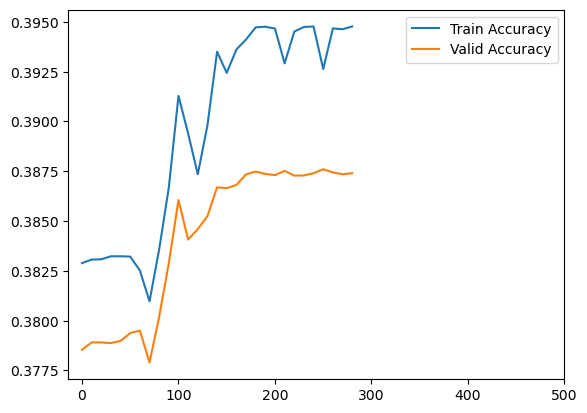

In [ ]:
import numpy as np
plt.plot(train_accs)
plt.plot(valid_accs)
plt.xticks(np.arange(0, 51, 10), np.arange(0, 510, 100))  # Set the x-ticks

plt.legend(["Train Accuracy", "Valid Accuracy"])
plt.show()

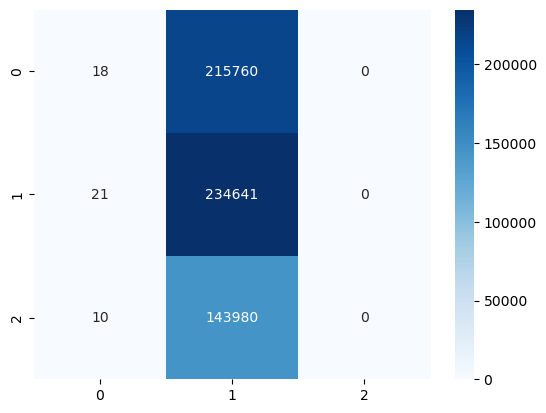

In [ ]:
embedded_model.eval()
output = embedded_model(data)
# edge_attr[:,-3] - train mask
mask_name = "train_masks"
mask = data['customer', 'order'][mask_name].bool().squeeze()
pred = F.softmax(output[mask], dim=-1)
target = data['customer', 'order'].label[mask].squeeze()
pred = pred.argmax(dim=-1)

cfm = confusion_matrix(target.cpu().numpy(), pred.cpu().numpy())
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')
plt.show()

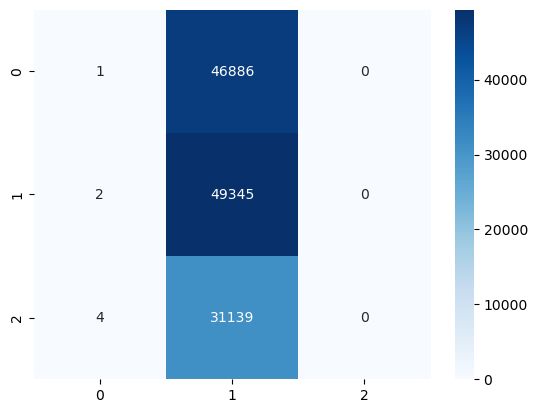

In [ ]:

embedded_model.eval()
output = embedded_model(data)
# edge_attr[:,-3] - train mask
mask_name = "valid_masks"
mask = data['customer', 'order'][mask_name].bool().squeeze()
pred = F.softmax(output[mask], dim=-1)
target = data['customer', 'order'].label[mask].squeeze()
pred = pred.argmax(dim=-1)

cfm = confusion_matrix(target.cpu().numpy(), pred.cpu().numpy())
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')
plt.show()

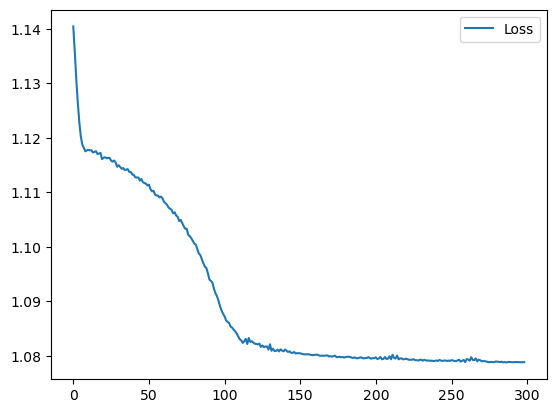

In [ ]:
plt.plot(losses)

plt.legend(["Loss"])
plt.show()

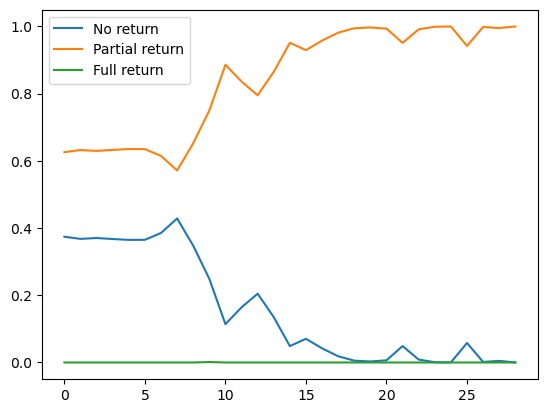

In [ ]:
import numpy as np
valid_dist = np.array(valid_dist)
plt.plot(valid_dist[:,0])
plt.plot(valid_dist[:,1])
plt.plot(valid_dist[:,2])
plt.legend(["No return", "Partial return", "Full return"])
plt.show()